In [36]:
import random
import math
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

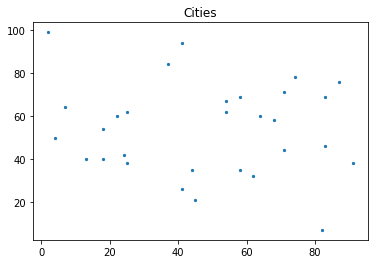

In [37]:
data = np.array(pd.read_excel("../dataSet/Oliver30.xlsx",header=None))
plt.title("Cities")
plt.scatter(data[:,0],data[:,1],s=5)
plt.show()

In [38]:
class PSO_4_TSP():
    def __init__(self, data, m, max_epoch):
        self.dist  = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵
        self.cityNums = data.shape[0]  #城市数目
        self.m  = m   # 粒子数目
        self.max_epoch = max_epoch #最大迭代次数
        self.area = data.shape[0]  # 最大范围限制，最小默认为0
        ptemp = list()
        # 初始化粒子群位置
        for i in range(self.m):
            ptemp.append(random.sample(range(self.cityNums), self.cityNums))
        self.particles = np.array(ptemp)#.T  # 粒子群位置
        self.pbestPositions = np.zeros((self.m, self.particles.shape[1])) # 粒子群个体的最佳位置-局部最优解   粒子数*城市数
        self.pbestValues = np.ones(self.m) * np.inf # 粒子群个体的最佳适应值-局部最优值   1*粒子数
        self.gbestSolution = self.pbestPositions[0] # 粒子群的最佳位置   1*城市数
        self.gbestValue = np.inf # 粒子群的最佳适应值   1
        return
    
    def calcuValue(self, solution):  # 计算状态值
        value = 0
        for c in range(self.cityNums-1):
            value += self.dist[int(solution[c]), int(solution[c+1])]
        value += self.dist[int(solution[0]), int(solution[-1])]
        return value
    
    def pbest(self):
        for i,p in enumerate(self.particles):
            fitValue = self.calcuValue(p)
            if fitValue < self.pbestValues[i]:
                self.pbestValues[i] = fitValue
                self.pbestPositions[i] = p
        return
    
    def update(self):   # 有序交叉法
        for k, i in enumerate(self.particles):
            x1 = i
            for flag in range(2):
                if flag == 0:
                    x = self.gbestSolution
                else:
                    x = self.pbestPositions[k]
                positions = random.sample(range(self.cityNums), 2)  # 随机两个交叉位
                positions.sort()
                com1  = list(x1[positions[0]:positions[1]+1])
                com2  = list(x[positions[0]:positions[1]+1])
                limit = list(range(positions[0])) + list(range(positions[1]+1, self.cityNums))
                for p in limit:            
                    temp = x1[p]
                    if x[p] not in com1:
                        x1[p] = x[p]
                    else:
                        index = com1.index(x[p])
                        while com2[index] in com1:
                            index = com1.index(com2[index])
                        x1[p] = com2[index]  
        return
    
    def electBest(self):
        for k, p in enumerate(self.pbestPositions):
            v = self.calcuValue(p)
            if v < self.gbestValue:
                self.gbestValue = v
                self.gbestSolution = self.pbestPositions[k]    
        return
    
    def evolute(self):
        i = 0 
        self.pbest()
        while i < self.max_epoch: # 达到最大迭代次数，停止迭代
            i += 1
            # 全局搜索
            self.update()
            self.pbest()
            # 选举出当前最优解/值
            self.electBest()
        print('最优解:', self.gbestSolution.astype(int))
        print('最优值:', self.gbestValue)
        return self.gbestValue, self.gbestSolution.astype(int).tolist()

In [39]:
class SA_4_TSP():
    def __init__(self, data, T0, alpha, L, TF, max_epoch):
        self.cityNums  = data.shape[0]  # 城市数目
        self.max_epoch = max_epoch # 最大迭代次数
        self.dist = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵
        self.alpha = alpha  # 降温系数
        self.T0 = T0  # 初始温度
        self.L  = L   # MARKOV链长
        self.TF = TF  # 终止温度
        self.solution = random.sample(range(self.cityNums), self.cityNums) # 初始解-城市的全排列 list类型
        self.value = self.calcuValue(self.solution)  # 计算当前状态值
        self.T = T0   # 当前温度
        return
    
    def calcuValue(self, solution):  # 计算状态值
        value = 0
        for c in range(self.cityNums-1):
            value += self.dist[solution[c], solution[c+1]]
        value += self.dist[solution[0], solution[-1]]
        return value
    
    def pick_from_Nx(self, x):  # 从当前状态领域中挑选一个状态
        # input x - 当前解 - 一个城市的全排列
        # return 城市的全排列 list类型
        exchange_index = sorted(random.sample(range(self.cityNums), 2))
        solution = x.copy()
        solution[exchange_index[0]] = self.solution[exchange_index[1]]
        solution[exchange_index[1]] = self.solution[exchange_index[0]]
        return solution
       
    def coolDown(self):  # 快速降温
        T = self.alpha * self.T 
        return T
    
    def evolute(self):  # 模拟退火过程
        t = 0 # 迭代次数
        while t < self.max_epoch:
            t += 1 # 当前迭代次数
            for i in range(self.L):
                newx = self.pick_from_Nx(self.solution)
                v = self.calcuValue(newx)
                delta = v - self.value   # 状态差值
                if delta < 0: # 更新状态
                    self.solution = newx  
                    self.value = v
                else:
                    r = random.random()
                    # 判断是否更新
                    if r <= np.exp(-delta / self.T):
                        self.solution = newx
                        self.value = v
            self.T = self.coolDown()  # 降温
        print('最优解:', self.solution)
        print('最优值:', self.value)
        return self.value, self.solution

In [40]:
class MA_PSO_SA_4_TSP:
    def __init__(self, data, T0, alpha, L, TF, m, startL, max_epoch):
        self.dist  = squareform(pdist(data, metric='euclidean'))  # 计算N个城市的距离矩阵
        self.cityNums = data.shape[0]  #城市数目
        self.alpha = alpha # 温度下降系数
        self.T0 = T0  # 初始温度
        self.L = L    # MARKOV链长
        self.startL = startL
        self.TF = TF  # 终止温度
        self.m  = m   # 粒子数目
        self.max_epoch = max_epoch #最大迭代次数
        self.area = data.shape[0]  # 最大范围限制，最小默认为0
        ptemp = list()
        # 初始化粒子群位置
        for i in range(self.m):
            ptemp.append(random.sample(range(self.cityNums), self.cityNums))
        self.particles = np.array(ptemp)#.T  # 粒子群位置
        self.pbestPositions = np.zeros((self.m, self.particles.shape[1])) # 粒子群个体的最佳位置-局部最优解   粒子数*城市数
        self.pbestValues = np.ones(self.m) * np.inf # 粒子群个体的最佳适应值-局部最优值   1*粒子数
        self.gbestSolution = self.pbestPositions[0] # 粒子群的最佳位置   1*城市数
        self.gbestValue = np.inf # 粒子群的最佳适应值   1
        return
    
    def calcuValue(self, solution):  # 计算状态值
        value = 0
        for c in range(self.cityNums-1):
            value += self.dist[int(solution[c]), int(solution[c+1])]
        value += self.dist[int(solution[0]), int(solution[-1])]
        return value
    
    def pick_from_Nx(self, x):  # 从当前状态领域中挑选一个状态
        # input x - 当前解 - 一个城市的全排列
        # return 城市的全排列 list类型
        positions = random.sample(range(self.cityNums), 2) # 随机两个变异点
        positions.sort()
        solution = x.copy()
        diff = (positions[1] - positions[0])/2
        for i in range(positions[0], math.ceil(diff+positions[0])):  # 倒置操作
            temp = solution[i]
            solution[i] = solution[int(i+(positions[0]+diff-i)*2)]
            solution[int(i+(positions[0]+diff-i)*2)] = temp
        return solution
    
    def coolDown(self):  # 快速降温
        T = self.alpha * self.T 
        return T
    
    '''def update1(self):
        for i, p in enumerate(self.particles):
            for j, k in enumerate(p):
                inertiaV =  self.w * self.speeds[i,j]  # 惯性速度
                selfCorrectV = self.c1 * np.random.random() *  (self.pbestPositions[i, j] - k) # 自身修正
                socialCorrectV = self.c2 * np.random.random() * (self.gbestSolution[j] - k)    # 社会修正
                self.speeds[i, j] = inertiaV + selfCorrectV + socialCorrectV  # 更新速度
                self.particles[i, j] = int(self.particles[i, j] + self.speeds[i, j])  # 更新位置
                if self.particles[i, j] > self.area:  # 越界合法性调整
                    self.particles[i, j] = self.area
                if self.particles[i, j] < 0:  # 越界合法性调整
                    self.particles[i, j] = 0
        return '''
    
    def update(self):   # 有序交叉法
        for k, i in enumerate(self.particles):
            x1 = i
            for flag in range(2):
                if flag == 0:
                    x = self.gbestSolution
                else:
                    x = self.pbestPositions[k]
                positions = random.sample(range(self.cityNums), 2)  # 随机两个交叉位
                positions.sort()
                com1  = list(x1[positions[0]:positions[1]+1])
                com2  = list(x[positions[0]:positions[1]+1])
                limit = list(range(positions[0])) + list(range(positions[1]+1, self.cityNums))
                for p in limit:            
                    temp = x1[p]
                    if x[p] not in com1:
                        x1[p] = x[p]
                    else:
                        index = com1.index(x[p])
                        while com2[index] in com1:
                            index = com1.index(com2[index])
                        x1[p] = com2[index]  
        return
    
    def startup(self):  #算法初启动时，对每个粒子进行邻域局部退火
        for k, p in enumerate(self.particles):  # 对每个粒子
            self.T = self.T0  #温度初始化
            while(True):
                for i in range(self.startL):   # 扰动self.startL次
                    newx = self.pick_from_Nx(p)
                    v = self.calcuValue(newx)
                    delta = v - self.pbestValues[k]   # 状态差值
                    if delta < 0: # 更新状态
                        self.pbestPositions[k] = newx
                        self.pbestValues[k] = v 
                    else:
                        r = random.random()
                        # 判断是否更新
                        if r <= np.exp(-delta / self.T):  
                            self.pbestPositions[k] = newx
                            self.pbestValues[k] = v 
                self.T = self.coolDown()  # 降温
                if self.T <= self.TF:  # 达到终止温度
                    break # 退出
        return
    
    def anneal(self):  # 对当轮粒子群局部最优解进行局部退火
        self.T = self.T0  #温度初始化
        while(True):
            for i in range(self.L):  # 扰动self.L次
                newx = self.pick_from_Nx(self.gbestSolution)
                v = self.calcuValue(newx)
                delta = v - self.gbestValue   # 状态差值
                if delta < 0: # 更新状态
                    self.gbestSolution = newx
                    self.gbestValue = v 
                else:
                    r = random.random()
                    # 判断是否更新
                    if r <= np.exp(-delta / self.T):  
                        self.gbestSolution = newx
                        self.gbestValue = v 
            self.T = self.coolDown()  # 降温
            if self.T <= self.TF:  # 达到终止温度
                break # 退出
        return
    
    def electBest(self):
        for k, p in enumerate(self.pbestPositions):
            v = self.calcuValue(p)
            if v < self.gbestValue:
                self.gbestValue = v
                self.gbestSolution = self.pbestPositions[k]    
        return
    
    def evolute(self):
        i = 0 
        self.startup()  #冷启动
        while i < self.max_epoch: # 达到最大迭代次数，停止迭代
            i += 1
            # 全局搜索
            self.update()
            # 局部搜索
            self.anneal()
            # 选举出当前最优解/值
            self.electBest()
        print('最优解:', self.gbestSolution.astype(int))
        print('最优值:', self.gbestValue)
        return self.gbestValue, self.gbestSolution.astype(int).tolist()

In [41]:
alpha = 0.8     # 降温系数
T0 = 2000       # 初温
L  = 1000       # MARKOV链长
TF = 0.01       # 终止温度
m  = 50         # 粒子数目
startL = 50     # 启动参数
max_epoch = 100 # 迭代次数

In [42]:
tpso = PSO_4_TSP(data, m, max_epoch)
v1, s1 = tpso.evolute()

最优解: [19 17  2  8 16 27 26 28  7 14 23 15 22 29  4 11 21 10 18  9 20 24 13  6
 25  3 12  5  1  0]
最优值: 702.1344985283952


In [53]:
sa = SA_4_TSP(data, T0, alpha, L, TF, max_epoch)
v2, s2 = sa.evolute()

最优解: [13, 14, 23, 26, 27, 15, 16, 11, 12, 3, 5, 4, 29, 22, 21, 28, 10, 6, 9, 20, 19, 18, 0, 1, 17, 2, 8, 25, 24, 7]
最优值: 503.3139168810851


In [51]:
mps = MA_PSO_SA_4_TSP(data, T0, alpha, L, TF, m, startL, max_epoch)
v3, s3 = mps.evolute()

最优解: [ 0  1  2  8 17 18 19 20  9 10  6  7 13 14 23 24 25 26 27 28 15 16 21 22
 29 11 12  3  4  5]
最优值: 423.7405631332029


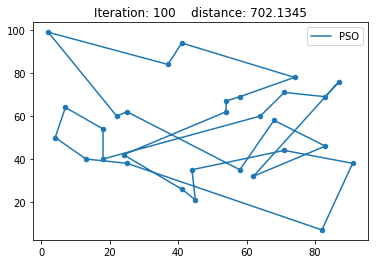

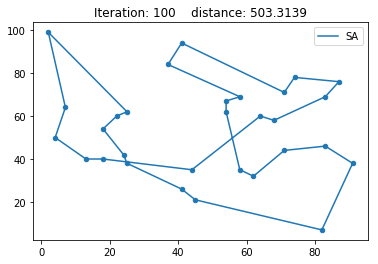

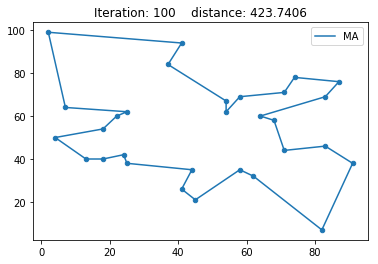

In [54]:
name = ['PSO','SA','MA']
s = [s1, s2, s3]
v = [v1, v2, v3]
for i in range(3):
    value = round(v[i], 4)
    solution = list(s[i])
    solution.append(solution[0])
    plt.title("Iteration: "+str(max_epoch)+"    distance: "+ str(value))
    plt.scatter(data[:,0], data[:,1],s=20)
    plt.plot(data[solution,0], data[solution,1], label = name[i])
    plt.legend()
    fileName = "%s%s%s%s" %(str(i),"最短路径",str(value),".png")
    plt.savefig(fileName)
    plt.show()